# Datset: Pairwise approach

Get tracksters from a certain neighbourhood.

Neighbourhood:
- get links from ticlNtuplizer/graph
    - figure out how these links are formed
- convert the tracksters into some latent space and predict a link between them
- later extend this using edgeconv or sageconf to add information from the neighbourhood

Graph:
- linked_inners
    - nodes linked to the given tracksters within its cone


In [1]:
import uproot
import torch
import random
import numpy as np

from reco.distance import euclidian_distance
from reco.matching import find_good_pairs
from reco.dataset import match_trackster_pairs, TracksterPairs
from reco.plotting import plot_tracksters
from reco.event import get_bary


import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

file_name = "~/data/multi/new_ntuples_14992862_991.root"

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})
graph = uproot.open({file_name: "ticlNtuplizer/graph"})

In [2]:
eid = 0

# prepare distance points
vx = tracksters["vertices_x"].array()[eid]
vy = tracksters["vertices_y"].array()[eid]
vz = tracksters["vertices_z"].array()[eid]
ve = tracksters["vertices_energy"].array()[eid]
clouds = [np.array([vx[tid], vy[tid], vz[tid]]).T for tid in range(len(vx))]

## Candidate pairs

Compile a list of candidate pairs based on the CLUE3D graph and node distance.

Reject all nodes with above a distance threshold.

In [3]:
MAX_DISTANCE = 10   # cm

candidate_pairs = []
distances = []

inners_list = graph["linked_inners"].array()[eid]
for i, inners in enumerate(inners_list):
    for inner in inners:
        dst = euclidian_distance(clouds[i], clouds[inner])
        distances.append(dst)
        if dst <= MAX_DISTANCE:
            candidate_pairs.append((i, inner))
            
print("Candidate pairs:", len(candidate_pairs))

Candidate pairs: 236


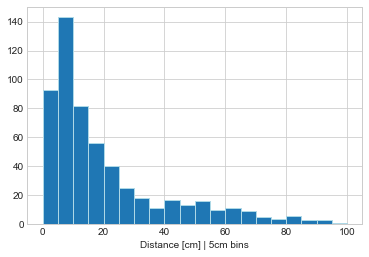

In [4]:
plt.hist(distances, bins=20, edgecolor="lightblue", range=(0, 100))
plt.xlabel("Distance [cm] | 5cm bins")
plt.show()

## Ground truth

In [5]:
gt_pairs = match_trackster_pairs(
    tracksters,
    simtracksters,
    associations,
    eid,
    distance_threshold=MAX_DISTANCE,
)
print("Ground truth pairs:", len(gt_pairs))

Ground truth pairs: 45


In [6]:
# sanity check
# all gold pairs are present in the candidate pairs

ab_pairs = set([(a, b) for a, b, _ in gt_pairs])
ba_pairs = set([(b, a) for a, b, _ in gt_pairs])
c_pairs = set(candidate_pairs)

matches = ab_pairs.union(ba_pairs).intersection(c_pairs)
not_matches = c_pairs - matches

# edges that are not the best but still correct
neutral = find_good_pairs(tracksters, associations, not_matches, eid)
positive = list(matches)
negative = random.sample(list(not_matches-neutral), k=len(matches))

print(f"positive: {len(positive)} negative: {len(not_matches)} negative selected: {len(set(negative))} neutral: {len(neutral)}")
assert len(matches) == len(gt_pairs)

positive: 45 negative: 191 negative selected: 45 neutral: 6


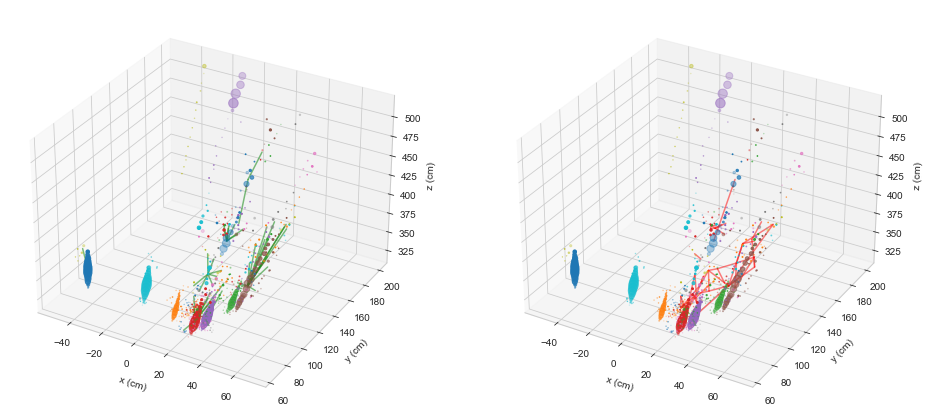

In [7]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
plot_tracksters(ax1, vx, vy, vz, ve)
plot_tracksters(ax2, vx, vy, vz, ve)
bary = get_bary(tracksters, eid)

def plot_edge(ax, edge, color):
    a, b = edge
    ca = bary[a]
    cb = bary[b]
    x = (ca[0], cb[0])
    y = (ca[1], cb[1])
    z = (ca[2], cb[2])
    ax.plot(x, y, z, c=color, alpha=0.5)

for edge in positive:
    plot_edge(ax1, edge, "green")

for edge in negative:
    plot_edge(ax2, edge, "red")

plt.show()

## Dataset

In [8]:
ds = TracksterPairs("data", N_FILES=2)
ds

<TracksterPairs len=11732 balanced=False max_distance=10 energy_threshold=10>

In [9]:
ds.x = torch.nn.functional.normalize(ds.x, p=torch.inf, dim=0)

In [10]:
ds[0]

(tensor([ 1.8108e-01, -4.3205e-01,  7.5715e-01,  1.9555e-02,  1.9931e-04,
          1.1910e-01,  1.3032e-02,  2.8208e-03,  1.3201e-01, -2.0414e-01,
          9.7191e-01,  3.4508e-01,  1.7046e-02,  1.1783e-01,  2.3435e-01,
         -4.2599e-01,  7.0940e-01,  3.5546e-03,  2.9795e-03,  8.5718e-02,
          3.2873e-02,  4.8178e-02,  7.9609e-02, -2.6732e-01,  9.6183e-01,
          2.5679e-01,  2.4765e-01,  6.9628e-02,  5.3571e-02,  1.0377e-01,
          3.0117e-01]),
 tensor(1.))

## Dummy evaluation

Let's talk baselines on this dataset. How good is a random guess?
How good is connecting to all nodes in a neighbourhood?

In [11]:
from reco.evaluation import pairwise_model_evaluation

In [12]:
class DummyModel:
    def eval(self):
        pass

class DummyPleaser(DummyModel):
    def __call__(self, X):
        return torch.tensor(np.ones(len(X)))

class DummyGuesser(DummyModel):
    def __call__(self, X):
        return torch.tensor(np.random.random(len(X)))

class DummyScaler:
    def transform(self, X):
        return X.tolist()

In [13]:
result = pairwise_model_evaluation(
    tracksters,
    simtracksters,
    associations,
    graph,
    DummyPleaser(),
    DummyScaler(),
    0.5,
    max_distance=15,
    energy_threshold=20,
)

Event 0:
	clue3d_to_sim:	P: 0.95 R: 0.32 F: 0.37
	target_to_sim:	P: 0.97 R: 0.76 F: 0.79
	reco_to_target:	P: 0.89 R: 0.86 F: 0.87
	reco_to_sim:	P: 0.91 R: 0.67 F: 0.71
Event 1:
	clue3d_to_sim:	P: 0.97 R: 0.29 F: 0.34
	target_to_sim:	P: 0.98 R: 0.66 F: 0.71
	reco_to_target:	P: 0.86 R: 0.88 F: 0.87
	reco_to_sim:	P: 0.94 R: 0.63 F: 0.68
Event 2:
	clue3d_to_sim:	P: 0.99 R: 0.20 F: 0.24
	target_to_sim:	P: 0.99 R: 0.56 F: 0.61
	reco_to_target:	P: 0.83 R: 0.70 F: 0.72
	reco_to_sim:	P: 0.95 R: 0.47 F: 0.52
Event 3:
	clue3d_to_sim:	P: 0.96 R: 0.23 F: 0.27
	target_to_sim:	P: 0.98 R: 0.61 F: 0.66
	reco_to_target:	P: 0.77 R: 0.67 F: 0.69
	reco_to_sim:	P: 0.94 R: 0.51 F: 0.57
Event 4:
	clue3d_to_sim:	P: 0.95 R: 0.19 F: 0.23
	target_to_sim:	P: 0.97 R: 0.58 F: 0.63
	reco_to_target:	P: 0.86 R: 0.81 F: 0.82
	reco_to_sim:	P: 0.95 R: 0.57 F: 0.62
Event 5:
	clue3d_to_sim:	P: 0.99 R: 0.58 F: 0.63
	target_to_sim:	P: 0.99 R: 0.79 F: 0.83
	reco_to_target:	P: 0.90 R: 0.89 F: 0.89
	reco_to_sim:	P: 0.94 R: 0.71 

In [14]:
for key, values in result.items():
    avg_p = np.mean([x[0] for x in values])
    avg_r = np.mean([x[1] for x in values])
    avg_f = np.mean([x[2] for x in values])

    print(f"mean {key}:\tP: {avg_p:.2f} R: {avg_r:.2f} F: {avg_f:.2f}")

mean clue3d_to_sim:	P: 0.97 R: 0.30 F: 0.35
mean target_to_sim:	P: 0.97 R: 0.65 F: 0.69
mean reco_to_target:	P: 0.85 R: 0.81 F: 0.82
mean reco_to_sim:	P: 0.94 R: 0.59 F: 0.63
